In [1]:
!pip install tensorflow -t ./

     |████████████████████████████████| 454.3 MB 12 kB/s s eta 0:00:01     |████████████████████████████▌   | 405.0 MB 68.9 MB/s eta 0:00:01     |██████████████████████████████▌ | 432.5 MB 68.9 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 65 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 77.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 45.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 44.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 45.5 MB/s eta 0:00:01
  Using cached cached_property-1.5.2-py2.

In [36]:
#import libraries
import boto3
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator 
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [37]:
all_miami = pd.read_csv('s3://partly-cloudy-ml-inputs/MIAMI_every_6_hour_flat.csv')
print(all_miami.head())

         localDateTime   Nx  Ny        Lat       Lon geoEncode   NAME  \
0  2020-06-01 00:00:00  233  33  24.921705 -81.27609     dhqjy  MIAMI   
1  2020-10-04 18:00:00  233  33  24.921705 -81.27609     dhqjy  MIAMI   
2  2020-10-23 18:00:00  233  33  24.921705 -81.27609     dhqjy  MIAMI   
3  2020-11-05 12:00:00  233  33  24.921705 -81.27609     dhqjy  MIAMI   
4  2020-12-12 12:00:00  233  33  24.921705 -81.27609     dhqjy  MIAMI   

   iSSRs200430  iSSRs300430  meanTemp200430  meanTemp300430  meanRH_ice200430  \
0            0            0      241.380000      228.127833         81.680833   
1            1            1      243.788250      230.275333         33.925833   
2            0            0      241.995833      228.875167         49.405833   
3            0            0      239.876000      227.803333         22.170833   
4            0            0      238.642750      225.028667         45.038333   

   meanRH_ice300430  
0         73.265000  
1         58.361667  
2       

In [39]:
df = all_miami[['localDateTime', 'iSSRs200430','Nx', 'Ny', 'meanTemp200430', 'meanRH_ice200430']]
#Filter down to the time period we want to examine
#Going to use May 11th at midnight to May 15th 2021 at midnight
df = df[df.localDateTime <= '2021-05-15 00:00:00']
df = df[df.localDateTime >= '2021-05-11 00:00:00']

In [40]:
#ensure date time filtering occured and checking data types for variables.
print(df.head())
print(df.info())

           localDateTime  iSSRs200430   Nx  Ny  meanTemp200430  \
40   2021-05-12 12:00:00            0  233  33      239.980583   
41   2021-05-13 00:00:00            0  233  33      240.298333   
219  2021-05-12 00:00:00            0  233  33      239.503083   
353  2021-05-14 12:00:00            0  233  33      238.922750   
388  2021-05-13 12:00:00            0  233  33      240.295917   

     meanRH_ice200430  
40          64.234167  
41          63.120000  
219         62.707500  
353         75.771667  
388         65.371667  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13957 entries, 40 to 1190428
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   localDateTime     13957 non-null  object 
 1   iSSRs200430       13957 non-null  int64  
 2   Nx                13957 non-null  int64  
 3   Ny                13957 non-null  int64  
 4   meanTemp200430    13957 non-null  float64
 5   meanRH_ice2004

In [41]:
#Convert variables into appropriate formats for analysis
#LocalDateTimePeriod -> Date object
df['localDateTime'] = pd.to_datetime(df['localDateTime'], infer_datetime_format=True)
#Check change has occured
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13957 entries, 40 to 1190428
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   localDateTime     13957 non-null  datetime64[ns]
 1   iSSRs200430       13957 non-null  int64         
 2   Nx                13957 non-null  int64         
 3   Ny                13957 non-null  int64         
 4   meanTemp200430    13957 non-null  float64       
 5   meanRH_ice200430  13957 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 763.3 KB


In [42]:
#Create dataframe just for our inputs - Focusing on FL 300-430
#Subsetting with ISSR count, cell locations, temperature, and relative humidity.

df_input =test_df[['iSSRs200430', 'Nx', 'Ny', 'meanTemp200430', 'meanRH_ice200430']]
print(df_input)

         iSSRs200430   Nx  Ny  meanTemp200430  meanRH_ice200430
353                0  233  33      238.922750         75.771667
1093               0  233  33      238.922500         33.183333
1278               0  233  33      239.559417         80.273333
1398               0  233  33      240.306583         61.123333
1467               0  242  37      238.844333         48.023333
...              ...  ...  ..             ...               ...
1188746            0  227  37      239.640000         86.507500
1189251            0  248  62      237.473333         55.523333
1189458            0  248  62      236.856250         59.329167
1189879            0  248  62      236.193417         35.971667
1190050            0  248  62      235.401583         15.040000

[3284 rows x 5 columns]


In [43]:
#Even though last 2 columns are float-64 want all input variables to be.
df_input= traindf_input.astype('float64')
#Checkout distribution of variables.
df_input.describe()

,iSSRs200430,Nx,Ny,meanTemp200430,meanRH_ice200430
count,1.131338e+06,1.131338e+06,1.131338e+06,1.131338e+06,1.131338e+06
mean,1.164674e-01,2.355371e+02,4.449452e+01,2.392555e+02,4.738263e+01
std,4.512848e-01,9.398356e+00,9.065420e+00,2.618881e+00,2.476856e+01
min,0.000000e+00,2.130000e+02,2.800000e+01,2.304304e+02,2.991667e+00
25%,0.000000e+00,2.280000e+02,3.700000e+01,2.372644e+02,2.674833e+01
50%,0.000000e+00,2.360000e+02,4.500000e+01,2.392927e+02,4.477750e+01
75%,0.000000e+00,2.430000e+02,5.100000e+01,2.413540e+02,6.644667e+01
max,4.000000e+00,2.550000e+02,6.300000e+01,2.467280e+02,1.015783e+02


In [44]:
#Scale inputs - Sigmoid and Tanh functions to normalize input variables.
scaler = StandardScaler()
data_scaled = scaler.fit_transform(traindf_input)
#scaled data is a 2D array all values are between 0-1.
data_scaled

array([[-0.25807973, -0.2699569 , -1.26795277,  0.81123807,  1.38474822],
       [ 1.95781689, -0.2699569 , -1.26795277,  1.73081072, -0.54330206],
       [-0.25807973, -0.2699569 , -1.26795277,  1.04638953,  0.08168419],
       ...,
       [-0.25807973,  1.32606769,  1.93101804, -1.03487585,  0.1566785 ],
       [-0.25807973,  1.32606769,  1.93101804, -1.49884654, -0.33941443],
       [-0.25807973,  1.32606769,  1.93101804, -2.56520588, -1.24694991]])

In [45]:
#store as feature variable
features = data_scaled
#our output/target variable is also pdISSRs200430 so will index for first part of array and store as target.
target = data_scaled[:,0]
print(target)

[-0.25807973  1.95781689 -0.25807973 ... -0.25807973 -0.25807973
 -0.25807973]


In [46]:
#store as feature variable
features = data_scaled
#our output/target variable is also pdISSRs200430 so will index for first part of array and store as target.
target = data_scaled[:,0]
print(target)

[-0.25807973  1.95781689 -0.25807973 ... -0.25807973 -0.25807973
 -0.25807973]


In [47]:
#Using timseriesgenerator to convert 2d to 3d arrays but also using a sample of data for this:
#Will update batch size to be larger later, length is the period of time in which we want to be able to predict
#Since data is in 6-hour increments, lets set length = 1 which means predicting 6 hours ahead.
#First row printed reflects our input values and the 2nd array printed is the output when predicting 6 hours ahead
#This prediction gives us an ISSR count of 0
TimeseriesGenerator(features_train, target_train, length = 1, sampling_rate = 1, batch_size =1)[0]

(array([[[-0.25807973, -0.2699569 , -1.26795277,  0.81123807,
           1.38474822]]]),
 array([1.95781689]))

In [48]:
#Split our data into training and testing data - 70% training & 30% testing. Also don't want to shuffle, keep
#order in tact

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.30,
random_state = 123, shuffle = False)

In [49]:
#Actual Timseries generator
#Data for every 6 hours, 24 hours we have 4 data points of 6 hours
#In day of 6 hour intervals we have 4 Data Points, we are taking 3 days of data so 4 x 365 = 1460 for window length
#5 features now.

#Each day we have 4 data points, we have 3 days of training data and using the 3 days of data going to print next
#observation. Batch size 32 - Each training instance, passing 32 batch size of data, with 5 features (input size)
win_length = 100
batch_size = 32
num_features = 5

#train generator - Passes the 70% of data, length is 12 for those 3 days of data and predict next instance.
train_generator = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate =1,batch_size = batch_size)
#test generator based on 30% of data
test_generator = TimeseriesGenerator(x_test, y_test, length = win_length, sampling_rate=1, batch_size = batch_size)

#Will contain 32 observations bc of the batch size variable each 12 having 5 observations bc 5 features
train_generator[0]

(array([[[-0.25807973, -0.2699569 , -1.26795277,  0.81123807,
           1.38474822],
         [ 1.95781689, -0.2699569 , -1.26795277,  1.73081072,
          -0.54330206],
         [-0.25807973, -0.2699569 , -1.26795277,  1.04638953,
           0.08168419],
         ...,
         [-0.25807973, -0.2699569 , -1.26795277,  0.24521993,
          -0.59053939],
         [-0.25807973, -0.2699569 , -1.26795277, -0.97791765,
          -0.82430363],
         [-0.25807973, -0.2699569 , -1.26795277,  1.26881289,
          -0.07190443]],
 
        [[ 1.95781689, -0.2699569 , -1.26795277,  1.73081072,
          -0.54330206],
         [-0.25807973, -0.2699569 , -1.26795277,  1.04638953,
           0.08168419],
         [-0.25807973, -0.2699569 , -1.26795277,  0.23694667,
          -1.01789595],
         ...,
         [-0.25807973, -0.2699569 , -1.26795277, -0.97791765,
          -0.82430363],
         [-0.25807973, -0.2699569 , -1.26795277,  1.26881289,
          -0.07190443],
         [-0.25807973, 

In [50]:
#Define our model architecture
model = Sequential()

#4(nm+n^2) where n - length of input vector in each time step (5) m - length of output vector (1)
#4(5*1 + 5^2) = 4(5 + 25) =4(30) = 120.

#telling LSTM layer number of units is 120, input shape is 12 instances with 5 features
#need hidden state for each observation
model.add(LSTM(120, activation='relu', input_shape = (win_length, num_features), return_sequences=True))
#model.add(LSTM(20, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 120)          60480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 120)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 1)            121       
Total params: 60,601
Trainable params: 60,601
Non-trainable params: 0
_________________________________________________________________


In [51]:
#early stopping is telling model to monitor the loss in the valiation dataset, will decrease for validation accuracy
#training will stop when chosen performance measure stops imporving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, mode='min')

In [ ]:
#defining model
model.compile(optimizer='adam', loss='mse', metrics = ['mse', 'accuracy'])
#passing training df. don't shuffle the data, for now validation and test will be the same - change in future.
history = model.fit(train_generator, epochs = 5, validation_data = test_generator, shuffle = False
                             ,callbacks=[early_stopping])

Epoch 1/5
24745/24745 [==============================] - ETA: 0s - loss: 1.0073 - mse: 1.0073 - accuracy: 0.0000e+00

In [ ]:
#Loss for each feature
print(history.history['loss'])
#Accuracy for each feature
print(history.history['accuracy'])
#Validation loss for each feature
print(history.history['val_loss'])
#Validation accuracy for each feature
print(history.history['val_accuracy'])

#plotting loss of training data vs. validation data loss for each epoch.
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
model.evaluate_generator(test_generator, verbose = 0)

In [21]:
#training_predictions = model.predict_generator(train_generator)
#print(training_predictions)

#using test generator data for the predictive model
predictions = model.predict_generator(test_generator)
print(predictions.shape[0])

print(predictions)

/home/ec2-user/SageMaker/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


4176
[[ 0.02172169]
 [ 0.00229769]
 [ 0.01307041]
 ...
 [-0.15081798]
 [-0.1481768 ]
 [-0.14081432]]


In [22]:
y_test

array([-0.35993784, -0.35993784, -0.35993784, ..., -0.35993784,
       -0.35993784, -0.35993784])

In [23]:
x_test

array([[-0.35993784, -1.44037493, -0.93702476,  1.3773957 ,  0.77528698],
       [-0.35993784, -1.44037493, -0.93702476, -0.46877835, -1.54778063],
       [-0.35993784, -1.44037493, -0.93702476,  0.70927777,  0.37010543],
       ...,
       [-0.35993784,  0.58125622, -1.26795277,  0.57160998, -0.28583079],
       [-0.35993784,  0.58125622, -1.26795277,  0.87756803, -1.63320137],
       [-0.35993784,  0.58125622, -1.26795277,  0.64349884, -0.29554225]])

In [24]:
x_test[:,1:][win_length:]

array([[-2.39798969,  0.16606863,  0.01061009,  0.64167148],
       [-2.39798969,  0.16606863,  0.3448509 ,  0.11431375],
       [-2.39798969,  0.16606863,  0.3329462 ,  0.84861274],
       ...,
       [ 0.58125622, -1.26795277,  0.57160998, -0.28583079],
       [ 0.58125622, -1.26795277,  0.87756803, -1.63320137],
       [ 0.58125622, -1.26795277,  0.64349884, -0.29554225]])

In [25]:
#df_train_pred = pd.concat([pd.DataFrame(training_predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
print(df_pred)

             0         0         1         2         3
0     0.021722 -2.397990  0.166069  0.010610  0.641671
1     0.002298 -2.397990  0.166069  0.344851  0.114314
2     0.013070 -2.397990  0.166069  0.332946  0.848613
3     0.005862 -2.397990  0.166069 -2.219036 -1.910290
4     0.039330 -2.397990  0.166069  1.036936  1.498494
...        ...       ...       ...       ...       ...
4171 -0.144174  0.581256 -1.267953  0.859129  0.539589
4172 -0.157618  0.581256 -1.267953  1.416019 -0.363060
4173 -0.150818  0.581256 -1.267953  0.571610 -0.285831
4174 -0.148177  0.581256 -1.267953  0.877568 -1.633201
4175 -0.140814  0.581256 -1.267953  0.643499 -0.295542

[4176 rows x 5 columns]


In [26]:
#Inversing the scaler
rev_trans = scaler.inverse_transform(df_pred)
print(rev_trans)

[[2.26246162e-01 2.13000000e+02 4.60000000e+01 2.38755542e+02
  7.46027778e+01]
 [2.14731698e-01 2.13000000e+02 4.60000000e+01 2.39138472e+02
  6.51073611e+01]
 [2.21117721e-01 2.13000000e+02 4.60000000e+01 2.39124833e+02
  7.83288889e+01]
 ...
 [1.23965376e-01 2.41000000e+02 3.30000000e+01 2.39398264e+02
  5.79025000e+01]
 [1.25531051e-01 2.41000000e+02 3.30000000e+01 2.39748792e+02
  3.36422222e+01]
 [1.29895501e-01 2.41000000e+02 3.30000000e+01 2.39480625e+02
  5.77276389e+01]]


In [27]:
df_final = df_input[predictions.shape[0]*-1:]
print(df_final)

         pdISSRs200430     Nx    Ny  pdMeanTemp200430  pdMeanRH_ice200430
836516             0.0  213.0  46.0        238.755542           74.602778
836613             0.0  213.0  46.0        239.138472           65.107361
836633             0.0  213.0  46.0        239.124833           78.328889
836733             0.0  213.0  46.0        236.201097           28.653056
836755             0.0  213.0  46.0        239.931375           90.030417
...                ...    ...   ...               ...                 ...
1193593            0.0  241.0  33.0        239.727667           72.764722
1193599            0.0  241.0  33.0        240.365681           56.511944
1193609            0.0  241.0  33.0        239.398264           57.902500
1193674            0.0  241.0  33.0        239.748792           33.642222
1193715            0.0  241.0  33.0        239.480625           57.727639

[4176 rows x 5 columns]


In [28]:
#Ensure count is correct.
df_final.count()

pdISSRs200430         4176
Nx                    4176
Ny                    4176
pdMeanTemp200430      4176
pdMeanRH_ice200430    4176
dtype: int64

In [29]:
df_final['ISSR_200430_Pred'] = rev_trans[:,0]
print(df_final)

         pdISSRs200430     Nx    Ny  pdMeanTemp200430  pdMeanRH_ice200430  \
836516             0.0  213.0  46.0        238.755542           74.602778   
836613             0.0  213.0  46.0        239.138472           65.107361   
836633             0.0  213.0  46.0        239.124833           78.328889   
836733             0.0  213.0  46.0        236.201097           28.653056   
836755             0.0  213.0  46.0        239.931375           90.030417   
...                ...    ...   ...               ...                 ...   
1193593            0.0  241.0  33.0        239.727667           72.764722   
1193599            0.0  241.0  33.0        240.365681           56.511944   
1193609            0.0  241.0  33.0        239.398264           57.902500   
1193674            0.0  241.0  33.0        239.748792           33.642222   
1193715            0.0  241.0  33.0        239.480625           57.727639   

         ISSR_200430_Pred  
836516           0.226246  
836613           0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<AxesSubplot:>

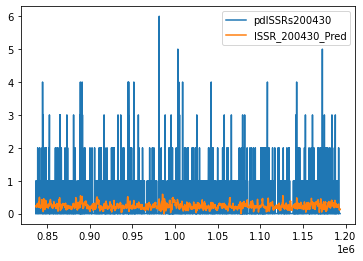

In [30]:
#Plot comparison of actual ISSR count for FL 200-430 (blue) and Predicted ISSR count (orange)
df_final[['pdISSRs200430', 'ISSR_200430_Pred']].plot()

In [31]:
round(df_final['ISSR_200430_Pred'],0)

836516     0.0
836613     0.0
836633     0.0
836733     0.0
836755     0.0
          ... 
1193593    0.0
1193599    0.0
1193609    0.0
1193674    0.0
1193715    0.0
Name: ISSR_200430_Pred, Length: 4176, dtype: float64

In [32]:
df_final['ISSR_200430_Pred'].describe()

count    4176.000000
mean        0.228577
std         0.083916
min        -0.010301
25%         0.173686
50%         0.215219
75%         0.275785
max         0.585328
Name: ISSR_200430_Pred, dtype: float64

In [33]:
#Distribution of predicted values
df_final['pdISSRs200430'].describe()

count    4176.000000
mean        0.201868
std         0.559047
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: pdISSRs200430, dtype: float64

In [34]:
print(df_final)

         pdISSRs200430     Nx    Ny  pdMeanTemp200430  pdMeanRH_ice200430  \
836516             0.0  213.0  46.0        238.755542           74.602778   
836613             0.0  213.0  46.0        239.138472           65.107361   
836633             0.0  213.0  46.0        239.124833           78.328889   
836733             0.0  213.0  46.0        236.201097           28.653056   
836755             0.0  213.0  46.0        239.931375           90.030417   
...                ...    ...   ...               ...                 ...   
1193593            0.0  241.0  33.0        239.727667           72.764722   
1193599            0.0  241.0  33.0        240.365681           56.511944   
1193609            0.0  241.0  33.0        239.398264           57.902500   
1193674            0.0  241.0  33.0        239.748792           33.642222   
1193715            0.0  241.0  33.0        239.480625           57.727639   

         ISSR_200430_Pred  
836516           0.226246  
836613           0.

In [35]:
print(df2)

         LocalDateTimePeriod  pdISSRs200430   Nx  Ny        Lat        Lon  \
34       2021-05-12 18:00:00              0  242  58  29.277510 -78.877894   
80       2021-05-13 12:00:00              2  242  58  29.277510 -78.877894   
255      2021-05-14 00:00:00              0  242  58  29.277510 -78.877894   
294      2021-05-13 18:00:00              1  242  58  29.277510 -78.877894   
361      2021-05-12 12:00:00              3  242  58  29.277510 -78.877894   
...                      ...            ...  ...  ..        ...        ...   
1193593  2021-05-14 06:00:00              0  241  33  24.765398 -79.674515   
1193599  2021-05-13 00:00:00              0  241  33  24.765398 -79.674515   
1193609  2021-05-12 06:00:00              0  241  33  24.765398 -79.674515   
1193674  2021-05-11 12:00:00              0  241  33  24.765398 -79.674515   
1193715  2021-05-12 00:00:00              0  241  33  24.765398 -79.674515   

         pdMeanTemp200430  pdMeanRH_ice200430  
34             

In [36]:
#last 30% of original dataframe - want to join the timestamp to predicted results
#https://stackoverflow.com/questions/14663004/how-to-get-the-last-n-rows-of-a-pandas-dataframe

df2 = df2.iloc[-4176:]
print(df2)

         LocalDateTimePeriod  pdISSRs200430   Nx  Ny        Lat        Lon  \
836516   2021-05-11 18:00:00              0  213  46  27.605318 -85.104425   
836613   2021-05-13 06:00:00              0  213  46  27.605318 -85.104425   
836633   2021-05-12 06:00:00              0  213  46  27.605318 -85.104425   
836733   2021-05-14 12:00:00              0  213  46  27.605318 -85.104425   
836755   2021-05-12 18:00:00              0  213  46  27.605318 -85.104425   
...                      ...            ...  ...  ..        ...        ...   
1193593  2021-05-14 06:00:00              0  241  33  24.765398 -79.674515   
1193599  2021-05-13 00:00:00              0  241  33  24.765398 -79.674515   
1193609  2021-05-12 06:00:00              0  241  33  24.765398 -79.674515   
1193674  2021-05-11 12:00:00              0  241  33  24.765398 -79.674515   
1193715  2021-05-12 00:00:00              0  241  33  24.765398 -79.674515   

         pdMeanTemp200430  pdMeanRH_ice200430  
836516         

In [37]:
#concat original date-time-stamp to results
df_final['datetime'] = df2['LocalDateTimePeriod']
df_final['Lat'] = df2['Lat']
df_final['Lon'] = df2['Lon']
print(df_final)

         pdISSRs200430     Nx    Ny  pdMeanTemp200430  pdMeanRH_ice200430  \
836516             0.0  213.0  46.0        238.755542           74.602778   
836613             0.0  213.0  46.0        239.138472           65.107361   
836633             0.0  213.0  46.0        239.124833           78.328889   
836733             0.0  213.0  46.0        236.201097           28.653056   
836755             0.0  213.0  46.0        239.931375           90.030417   
...                ...    ...   ...               ...                 ...   
1193593            0.0  241.0  33.0        239.727667           72.764722   
1193599            0.0  241.0  33.0        240.365681           56.511944   
1193609            0.0  241.0  33.0        239.398264           57.902500   
1193674            0.0  241.0  33.0        239.748792           33.642222   
1193715            0.0  241.0  33.0        239.480625           57.727639   

         ISSR_200430_Pred             datetime        Lat        Lon  
8365

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [38]:
df_final.info()

#date column not datetime type
df_final['datetime'] = pd.to_datetime(df_final['datetime']) 
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 836516 to 1193715
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pdISSRs200430       4176 non-null   float64
 1   Nx                  4176 non-null   float64
 2   Ny                  4176 non-null   float64
 3   pdMeanTemp200430    4176 non-null   float64
 4   pdMeanRH_ice200430  4176 non-null   float64
 5   ISSR_200430_Pred    4176 non-null   float64
 6   datetime            4176 non-null   object 
 7   Lat                 4176 non-null   float64
 8   Lon                 4176 non-null   float64
dtypes: float64(8), object(1)
memory usage: 326.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4176 entries, 836516 to 1193715
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pdISSRs200430       4176 non-null   float64       
 1   Nx    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
df_final['datetime'].value_counts()

2021-05-12 06:00:00    246
2021-05-13 12:00:00    246
2021-05-13 06:00:00    246
2021-05-12 12:00:00    246
2021-05-15 00:00:00    246
2021-05-11 18:00:00    246
2021-05-11 00:00:00    246
2021-05-12 18:00:00    246
2021-05-14 12:00:00    246
2021-05-11 06:00:00    246
2021-05-14 18:00:00    246
2021-05-13 00:00:00    245
2021-05-14 06:00:00    245
2021-05-12 00:00:00    245
2021-05-13 18:00:00    245
2021-05-14 00:00:00    245
2021-05-11 12:00:00    245
Name: datetime, dtype: int64

In [40]:
#output bucket - S3 bucket designaton
output_bucket = 'partly-cloudy-common-area'
outputFileName = 'Miami_Results_FL200430.csv' 

In [41]:
#use wrangler to write the dataframe into a CSV.
wr.s3.to_csv(df_final, f"s3://{output_bucket}/{outputFileName}", index=False)

{'paths': ['s3://partly-cloudy-common-area/Miami_Results_FL200430.csv'],
 'partitions_values': {}}

In [42]:
results = (pd.to_datetime(df_final['datetime']).dt.floor('6h').value_counts().rename_axis('date').reset_index(name = 'count'))

In [43]:
#results counted based on how many data points for each date.
print(results)

                  date  count
0  2021-05-12 06:00:00    246
1  2021-05-13 12:00:00    246
2  2021-05-13 06:00:00    246
3  2021-05-12 12:00:00    246
4  2021-05-15 00:00:00    246
5  2021-05-11 18:00:00    246
6  2021-05-11 00:00:00    246
7  2021-05-12 18:00:00    246
8  2021-05-14 12:00:00    246
9  2021-05-11 06:00:00    246
10 2021-05-14 18:00:00    246
11 2021-05-13 00:00:00    245
12 2021-05-14 06:00:00    245
13 2021-05-12 00:00:00    245
14 2021-05-13 18:00:00    245
15 2021-05-14 00:00:00    245
16 2021-05-11 12:00:00    245


In [44]:
#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
#https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
df_ISSR_counts = df_final[['datetime', 'pdISSRs200430', 'ISSR_200430_Pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='datetime').sum()


#df_ISSR_counts.resample('D', on='datetime').mean()

                   datetime  pdISSRs200430  ISSR_200430_Pred
836516  2021-05-11 18:00:00            0.0          0.226246
836613  2021-05-13 06:00:00            0.0          0.214732
836633  2021-05-12 06:00:00            0.0          0.221118
836733  2021-05-14 12:00:00            0.0          0.216844
836755  2021-05-12 18:00:00            0.0          0.236684
...                     ...            ...               ...
1193593 2021-05-14 06:00:00            0.0          0.127904
1193599 2021-05-13 00:00:00            0.0          0.119934
1193609 2021-05-12 06:00:00            0.0          0.123965
1193674 2021-05-11 12:00:00            0.0          0.125531
1193715 2021-05-12 00:00:00            0.0          0.129896

[4176 rows x 3 columns]


,pdISSRs200430,ISSR_200430_Pred
datetime,,
2021-05-11,174.0,225.006334
2021-05-12,245.0,225.712903
2021-05-13,192.0,221.582942
2021-05-14,232.0,225.390324
2021-05-15,0.0,56.844835


In [45]:
#Actual vs. Predicted at each 6 hour interval
df_ISSR_counts.resample('6H', on='datetime').sum()

,pdISSRs200430,ISSR_200430_Pred
datetime,,
2021-05-11 00:00:00,56.0,54.977334
2021-05-11 06:00:00,22.0,55.720300
2021-05-11 12:00:00,46.0,56.859851
2021-05-11 18:00:00,50.0,57.448849
2021-05-12 00:00:00,54.0,58.069962
2021-05-12 06:00:00,58.0,56.201046
2021-05-12 12:00:00,93.0,54.834053
2021-05-12 18:00:00,40.0,56.607841
2021-05-13 00:00:00,103.0,56.702736


In [46]:
df_6_ISSR_count = df_ISSR_counts.resample('6H', on='datetime').sum()

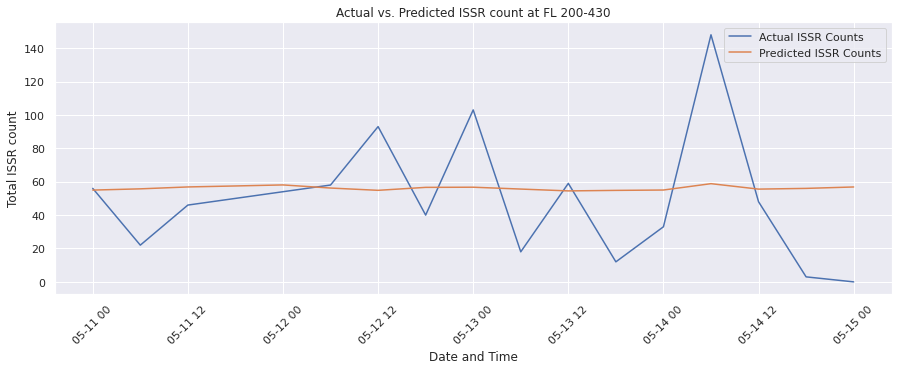

In [59]:
sns.lineplot(x = 'datetime', y = 'pdISSRs200430', data = df_6_ISSR_count,)
sns.lineplot(x = 'datetime', y = 'ISSR_200430_Pred', data = df_6_ISSR_count)
plt.title('Actual vs. Predicted ISSR count at FL 200-430')
plt.xlabel('Date and Time')
plt.ylabel ('Total ISSR count')
plt.xticks(rotation = 45)
sns.set(rc={'figure.figsize':(15,5)})
plt.legend(labels=["Actual ISSR Counts","Predicted ISSR Counts"])

plt.show()